parser:
Where we need more BB?
1- if-else
2- while
3- for

In [13]:
import collections 
import inspect
import copy  
from collections import defaultdict

In [68]:
%run tokenizer.ipynb
%run util.ipynb
        
class Reg():
    def __init__(self):
        self.num=5
        self.occ= [0]*self.num 
        
    def AllocateReg(self):pass
    def DeAllocateReg(self,i):pass        
    def emit(self,bb,op,x=None,y=None):pass
    def load(self,x,bb): pass #get from the parser_compute
    
    def emit1(self,bb,op,s):
        line="("+str(self.get_SSA_current_line()+1)+") : "+op +" " +s
        self.node[bb]["code"].append(line)
    
    def compute_SSA(self,x,y,op,bb):
        if op=="MOVE":
            self.emit1(bb,op,"("+str(self.get_SSA_table_variable(x,bb))+"),("+str(self.get_SSA_table_variable(y.real_value,bb))+")")
        if op in opCode.keys():
            if x.kind=='constant' and y==None: #let a<-1;
                self.emit1(bb,"None","#")
            elif x.kind=='var' and y==None: #let a<-1;
                self.emit1(bb,"None",x.real_value)
            elif x.kind=='constant' and y.kind=='constant':
                x.val= eval(str(x.val) + op + str(y.val))
                #dont know the correct OP
                self.emit1(bb,"ADDI","#"+str(x.val))
            else:
                if x.kind=='constant':
                    x,y=y,x
                    self.emit1(bb,opCode[op],"("+str(self.get_SSA_table_variable(x.real_value,bb))+"),"+"#"+str(y.val))
                elif y.kind=='constant':
                    self.emit1(bb,opCode[op],"("+str(self.get_SSA_table_variable(x.real_value,bb))+"),"+"#"+str(y.val))
                else:
                    self.emit1(bb,opCode[op],"("+str(self.get_SSA_table_variable(x.real_value,bb))+"),("+str(self.get_SSA_table_variable(y.real_value,bb))+")")
            #print("compute_SSA",x)
            return x
        elif op in ["CMP"]:
            if x.kind=='constant' and y.kind=='constant':
                #can be optimized!!
                #x.val= eval(str(x.val) + op + str(y.val))
                #dont know the correct OP
                self.emit1(bb,"CMP","#"+str(x.val)+"#"+str(y.val))
            else:
                if x.kind=='constant':
                    self.emit1(bb,"CMP","#"+str(x.val)+","+str(self.get_SSA_table_variable(y.real_value,bb)))
                elif y.kind=='constant':
                    self.emit1(bb,"CMP","("+str(self.get_SSA_table_variable(x.real_value,bb))+"),"+"#"+str(y.val))
                else:
                    self.emit1(bb,"CMP","("+str(self.get_SSA_table_variable(x.real_value,bb))+"),("+str(self.get_SSA_table_variable(y.real_value,bb))+")")
                self.add_SSA_current_line()
                
        elif op in opRel.keys():
            jump_add="where?"
            try:
                jump_add=self.node[x]["code"][0].split(" ")[0]
            except:
                print("!!! could not find the first line of block:",x)
                pass
            self.emit1(bb,opRel[op],jump_add)
            self.add_SSA_current_line()
        elif op in ["BRA"]:
            jump_add="where?"
            #jump address is the first SSA number of merge block (passed as X)
            try:
                jump_add=self.node[x]["code"][0].split(" ")[0]
            except:
                print("!!! could not find the first line of block:",x)
                pass
            self.emit1(bb,"BRA",jump_add)
            self.add_SSA_current_line()
        else:
            print("!!!! could not find the operation:",op)
            
    def insert_phi(self,bb,var,left_line,right_line):
        print("inserting phi...")
        self.emit1(bb,'Phi',"("+str(left_line)+","+str(right_line)+")")
        self.add_SSA_table(var,bb)
        
    
class SSA():
    def __init__(self):
        self.SSA_current_line=0

    def add_SSA_current_line(self):
        self.SSA_current_line+=1
        return self.SSA_current_line
    
    def get_SSA_current_line(self):
        return self.SSA_current_line       
    
    def add_SSA_table(self,x,bb):
        self.node[bb]["SSA_table"][x].append(self.add_SSA_current_line())
        
    def get_SSA_table_variable(self,x,bb):
        if x in self.node[bb]["SSA_table"].keys():
            pass
        else:
            #what about variables without initilization?
            return -1
        return self.node[bb]["SSA_table"][x][-1]
    
    def copy_SSA_table(self,bb):
        #copy the parent's SSA table
        if len(self.node[bb]["parents"])==1:
            self.node[bb]["SSA_table"]=copy.deepcopy(self.node[self.node[bb]["parents"][0]]["SSA_table"])
        else:#in the case of 'if' or 'while': compare the two SSA table and merge them using Phi
            for p in self.node[bb]["parents"]:
                for k,v in self.node[p]["SSA_table"].items():
                    if k not in self.node[bb]["SSA_table"].keys():
                        self.node[bb]["SSA_table"][k]=copy.deepcopy(v)
                    elif self.node[bb]["SSA_table"][k]==v:
                        continue
                    else:#insert Phi
                        self.insert_phi(bb,k,self.node[bb]["SSA_table"][k][-1],self.node[p]["SSA_table"][k][-1])    
        
    def __repr__(self):
        return self.SSA_variable_table
    
class parser(SSA,Reg,parser_util,BB):
    def __init__(self,tokens,rules):
        self.tokens=collections.deque([i for i in tokens if i.type!='COMMENT'])
        self.rules=rules
        self.current_bb=0
        SSA.__init__(self)
        Reg.__init__(self)
        parser_util.__init__(self)
        BB.__init__(self)
        
    def check_assignment(self,bb):
        self.must_parse("let")
        indent=self.check_designator(bb)
        self.must_parse("ASSIGN")
        result_x=self.check_expression(bb)
        self.add_SSA_table(indent,bb)
        self.compute_SSA(indent,result_x,"MOVE",bb)
        #self.emit1(bb,"","")
   

    def check_whileStatement(self,bb):
        self.must_parse("while")
        self.check_relation(bb)
        self.must_parse("do")
        self.check_stat_Sequence(bb)
        self.must_parse("od")
        
    
    def check_ifStatement(self,bb):
        mother_bb=bb
        self.must_parse("if")
        op=self.check_relation(bb)
        
        self.must_parse("then")
        newbbif=self.new_bb([bb])        
        self.check_stat_Sequence(newbbif)        
        
        next_bb=[newbbif]
        flag_else=False
        if self.tokens[0].type=="else":
            flag_else=True
            self.must_parse("else")
            newbbelse=self.new_bb([bb])
            next_bb.append(newbbelse)
            self.check_stat_Sequence(newbbelse)

        self.must_parse("fi")
        
        #adding branch to the end of BBs
        merge_bb=self.new_bb(next_bb)
        #bra at the end of if block(newbbif), jumping to the beginning of merge block(merge_bb)!
        self.compute_SSA(merge_bb,None,"BRA",newbbif)        #(x,y,op,bb)
        #bra at the end of mother block(mother_bb), jumping to the beginning else/merge block(newbbelse/merge_bb)!
        if flag_else:
            self.compute_SSA(newbbelse,None,op,mother_bb)
        else:
            self.compute_SSA(merge_bb,None,op,mother_bb)
        
        return merge_bb

    
    def check_factor(self,bb):
        result=Result(None,None,None,None,None)
        if self.tokens[0].type not in ["INDENT","NUMBER","OPEN_P","call"]:
            print("error,check_factor!!!",self.tokens[0],inspect.stack()[1][3])
        if self.tokens[0].type=="INDENT":
            #TODO:what about array?
            result.kind,result.address,result.real_value='var',self.tokens[0].value,self.tokens[0].real_value
            indent=self.check_designator(bb)              
            indent_SSA_table=self.get_SSA_table_variable(indent,bb)
            print("======",indent,"indent_SSA_table",indent_SSA_table)
            
        if self.tokens[0].type=="NUMBER":
            result.kind,result.val='constant',self.tokens[0].value 
            self.must_parse("NUMBER")            
        if self.tokens[0].type=="OPEN_P":
            self.must_parse("OPEN_P")
            result=self.check_expression(bb)
            self.must_parse("CLOSE_P")
        if self.tokens[0].type=="call":
            self.check_funcCall()
        #print(result)
        return result
            
    
    def check_expression(self,bb):
        result_x=self.check_term(bb)
        #if result_x.kind!="constant":
        #    result_x.real_value="temp+for+internalUse"
        #    self.add_SSA_table("temp+for+internalUse",bb)
        #flag=1
        while self.tokens[0].value in ["+","-"]:            
            op=self.tokens[0].value
            self.must_parse("OP")
            result_y=self.check_term(bb)
            result_x=self.compute_SSA(result_x,result_y,op,bb)
            if result_x.kind!="constant":
                result_x.real_value="temp+for+internalUse"
                self.add_SSA_table("temp+for+internalUse",bb)
            flag=0
        #case let y<-1;
        #if flag==1: result_x=self.compute_SSA(result_x,None,"None",bb)
        return result_x

0 1 ('check_stat_Sequence:', 0, 'check_computation')
1 ('!!!! could not find the operation:', 'MOVE')
0 ('!!!! could not find the operation:', 'MOVE')
2 3 ('======', 'y', 'indent_SSA_table', -1)
('!!!! could not find the operation:', 'MOVE')
0 ('!!!! could not find the operation:', 'MOVE')
0 4 ('======', 'c', 'indent_SSA_table', -1)
1 ('======', 'b', 'indent_SSA_table', 1)
('!!!! could not find the operation:', 'MOVE')
0 0 ('======', 'a', 'indent_SSA_table', 6)
1 ('======', 'b', 'indent_SSA_table', 1)
0 ('======', 'a', 'indent_SSA_table', 6)
1 ('======', 'b', 'indent_SSA_table', 1)
('!!!! could not find the operation:', 'MOVE')
0 0 ('======', 'a', 'indent_SSA_table', 11)
('!!!! could not find the operation:', 'MOVE')
^^^^ printing BBs:
[0]
('====BB=====', 0)
(2) : MOVE (1),(-1)
(3) : MOVE (2),(-1)
(4) : MOVE (3),(-1)
(5) : MOVE (4),(-1)
(5) : ADD (-1),(1)
(7) : MOVE (6),(5)
(7) : ADDI #13
(7) : ADD (6),#13
(8) : ADD (7),(1)
(9) : ADD (8),(6)
(10) : ADD (9),(1)
(12) : MOVE (11),(10)
(12

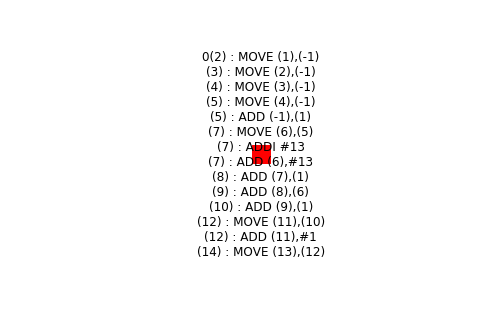

In [70]:
code='''
main
var a, b;
{
let b <- 1;
let a <- 2;
let x <- y;
let a <- 2;
let a <- c+b;
let a <-  5+ 8 + a + b + a +b;
let a <-  a + 1
#if a > 1 then
#let x <- a + 4
#else
#let y <- b * 5
#fi;
#let a <- a + b
#;
#if a < b then
#let a <- a - 1
#fi
}.'''
%matplotlib inline
    
def testa(code):
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(code)
    c=parser(tk.result,rules) 
    c.check_computation()
    c.print_bb()
    c.visulize()
testa(code)


import os
path="/home/ahmad/Documents/compiler/project/testprogs/"
for files in os.listdir(path):
    print(files,"==========")
    a="".join([lines for lines in open(path+files,'r')])
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(a)
    c=parser(tk.result,rules)
    c.check_computation()
    #tk.tokenize_program(code)

x= 3 <br>
y= x+1; <br>
a= x + y; <br>
=====> <br> : first load, and then add, will preserve the original value<br>
(1) addi x,#3<br>
(2) add x1,#1; <br>
(3) move (2),y <br>
(4) add x1,y <br>
(5) move x1,a <br>
==========><br>
One pass: <br>
(1) addi x,#3 <br>
---add x,1 to SSA table <br>
(2) add (1),#1<br>
---add y,2 to SSA table <br>
(3) add (1),(2)<br>

Test021:<br>
	let a <- 1;<br>
	let b <- 2;<br>
	let a <- a * b * 7 * a;<br>
	let a <- a + b<br>
==========><br>
(1) addi a,#1<br>
(2) addi b,#2; <br>
(3) MUL (1),(2) <br>
(4) MUL (3),#7 <br>
(5) MUL (3),(1) <br>
(6) add (5),(2) <br>


In [14]:
# to do: 
#deal with a= a+b+c+d+a
#deal with a= 1
#complete the while SSA generator
#remove redundant computations: a<-x+y  b<-x+y
#make 'live' graph of the SSA variables
#deal with arrays
#deal with functions/procedures
#deal with reserved functions: write, read,...
#deal with uninitilized variables